# Time Series Forecasting with XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

df = pd.read_csv('AEP_hourly.csv')
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


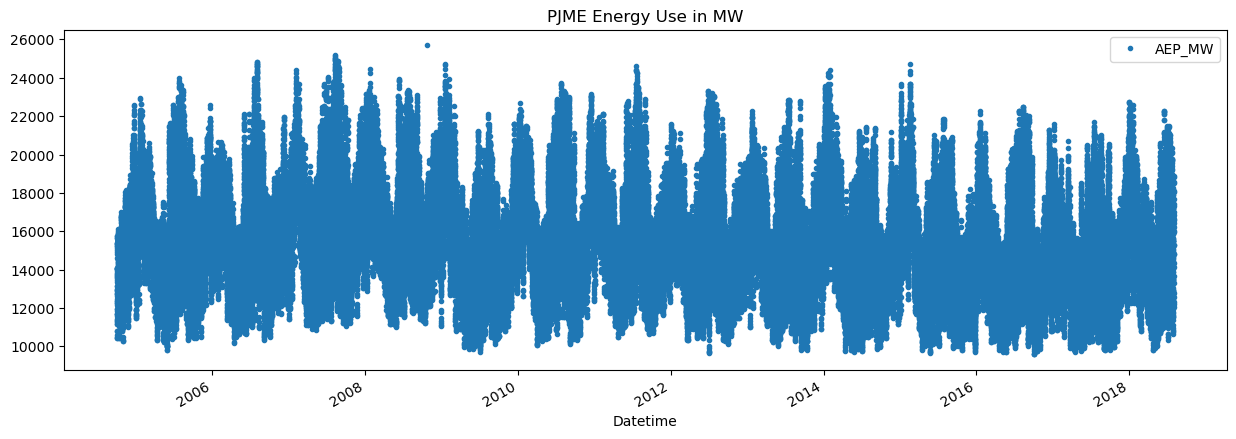

Timestamp('2018-08-03 00:00:00')

In [3]:
color_pal = sns.color_palette()
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='AEP Energy Use in MW')
plt.show()

# Split data into train/test

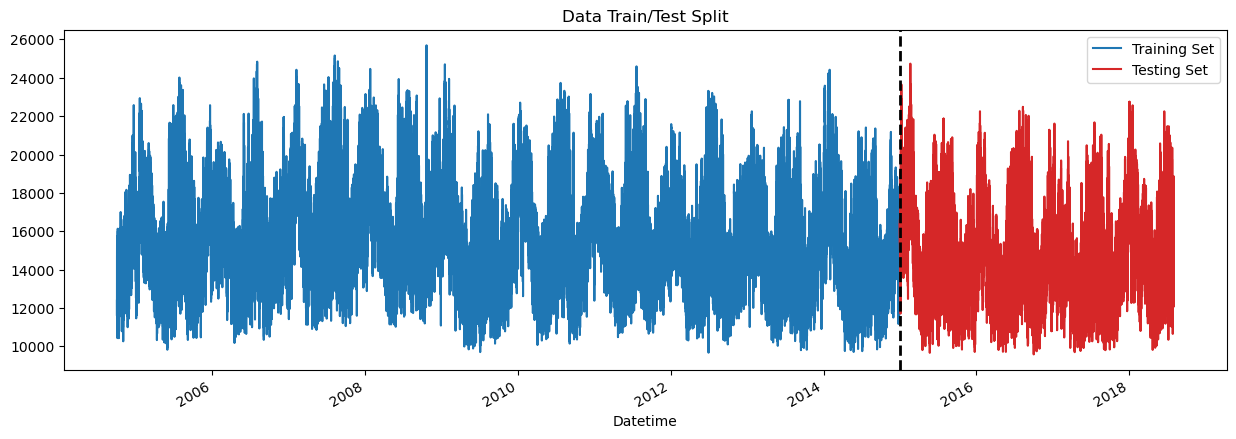

In [24]:
split_date = pd.to_datetime('2015-01-01')
train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax = ax,
           label = 'Training Set',
           color = 'tab:blue')
test.plot(ax = ax,
          label = 'Test Set',
          color = 'tab:red')
ax.axvline(split_date, 
           color = 'black',
           ls = '--',
           linewidth = 2)
ax.set_title('Data Train/Test Split')
ax.legend(['Training Set', 'Testing Set'])
plt.show()

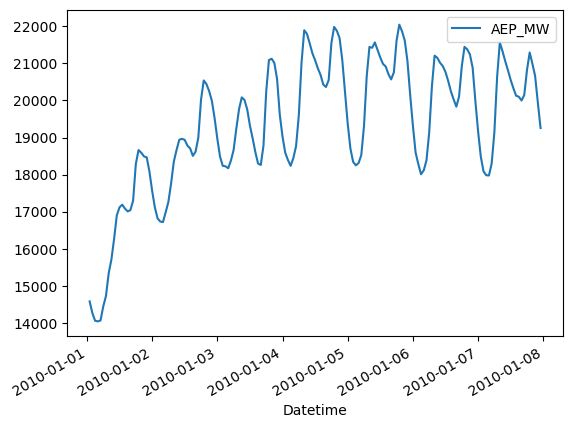

In [26]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot();

# Feature Creation

In [44]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [46]:
df = create_features(df)

# Visualize our Feature

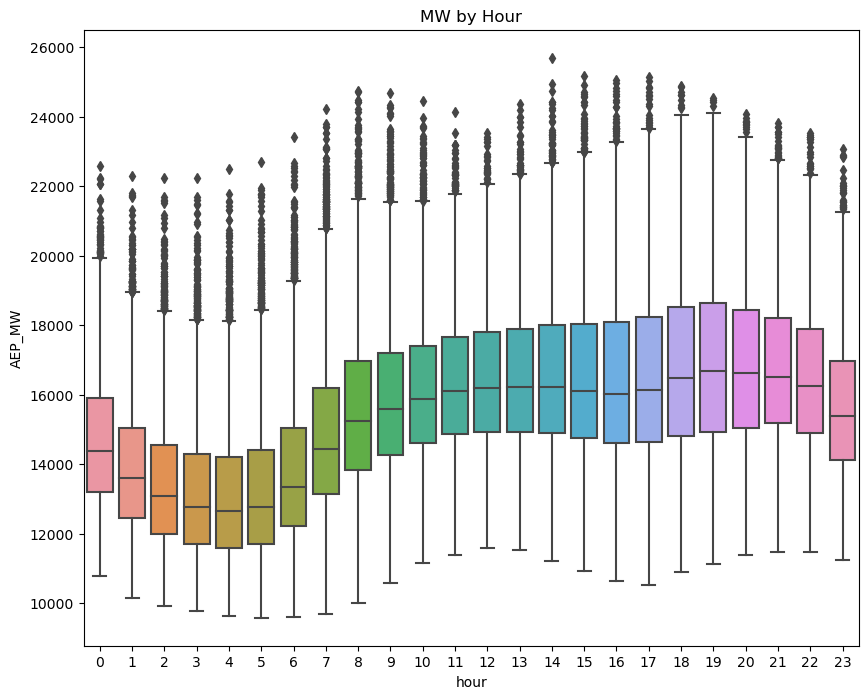

In [40]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df,
            x = 'hour',
            y = 'AEP_MW')
ax.set_title('MW by Hour');

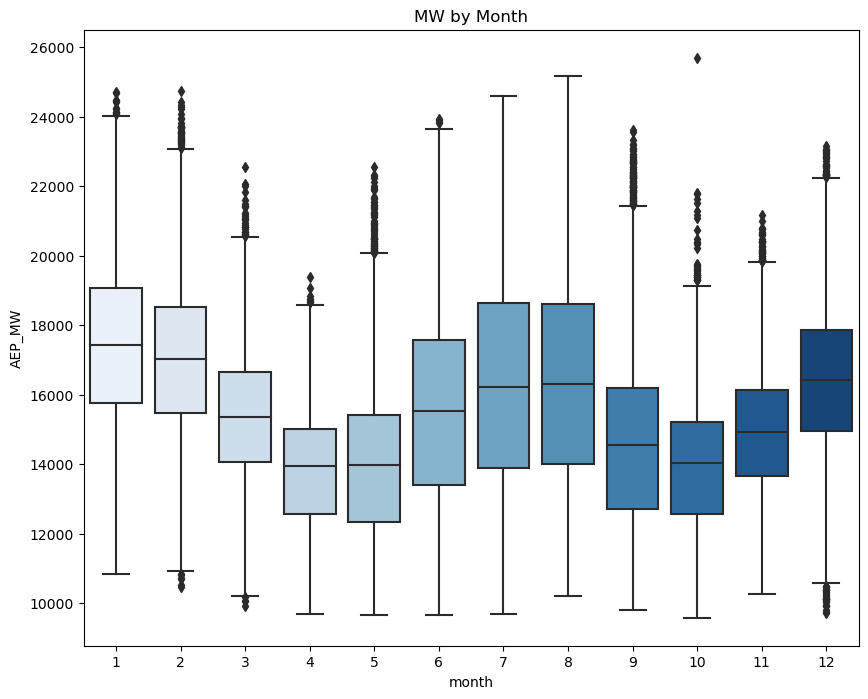

In [42]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df,
            x = 'month',
            y = 'AEP_MW',
           palette = 'Blues')
ax.set_title('MW by Month');

# Create our Model

In [56]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'AEP_MW'

In [58]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [62]:
reg = xgb.XGBRegressor(n_estimators = 1000,
                       early_stopping_rounds = 50,
                       learning_rate = 0.01)
reg.fit(X_train, Y_train,
        eval_set = [(X_train, Y_train), (X_test, Y_test)],
        verbose = 100)

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[100]	validation_0-rmse:1667.99304	validation_1-rmse:1906.43321
[200]	validation_0-rmse:1388.41609	validation_1-rmse:1728.03964
[300]	validation_0-rmse:1260.06288	validation_1-rmse:1670.93868
[400]	validation_0-rmse:1170.54347	validation_1-rmse:1651.83339
[500]	validation_0-rmse:1113.48343	validation_1-rmse:1644.49126
[545]	validation_0-rmse:1091.20163	validation_1-rmse:1647.88201


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

# Feature Importance

In [67]:
fi = pd.DataFrame(reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['importance'])

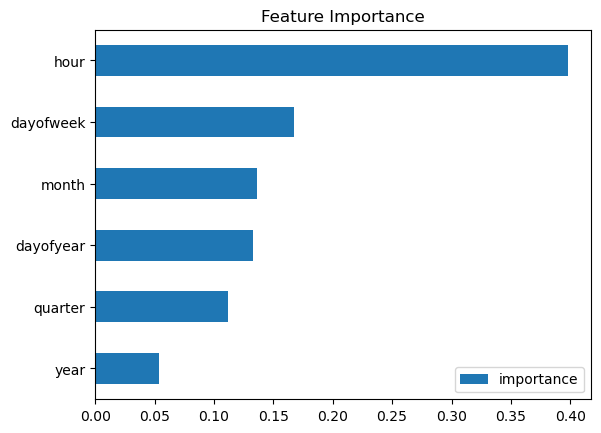

In [70]:
fi.sort_values('importance').plot(kind = 'barh',
                                  title = 'Feature Importance')
plt.show();

# Forecast on Test

In [72]:
test['prediction'] = reg.predict(X_test)

In [75]:
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

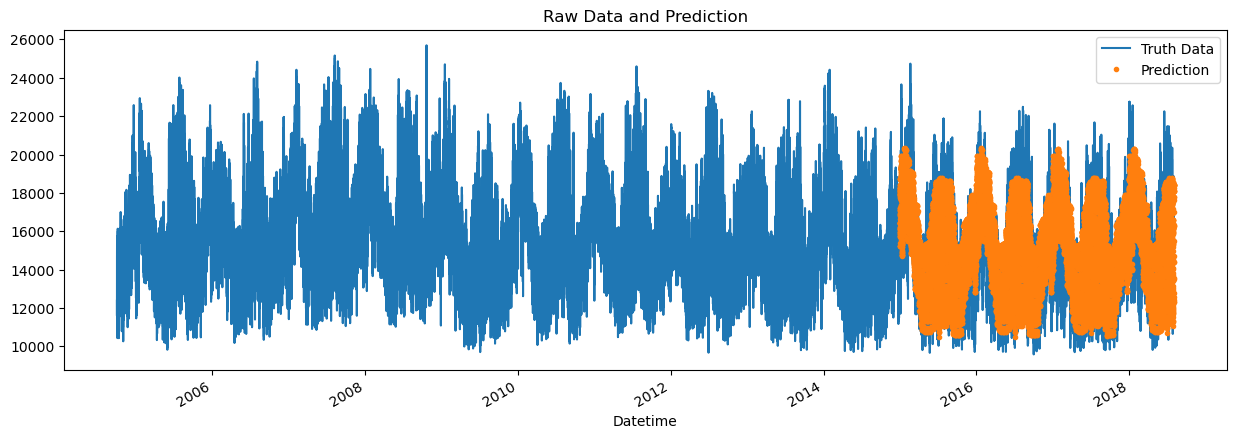

In [76]:
ax = df[['AEP_MW']].plot(figsize = (15, 5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

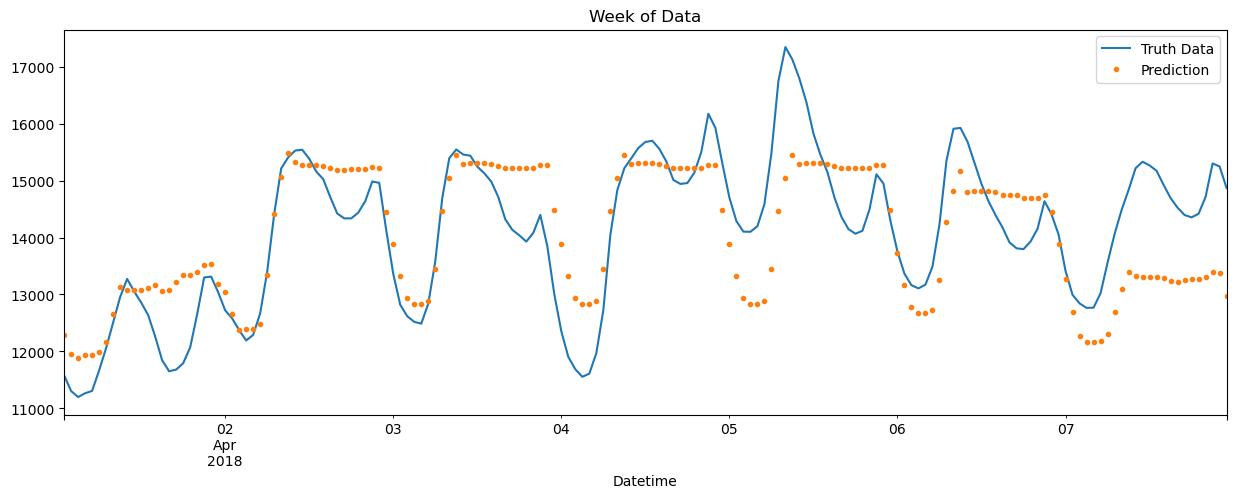

In [78]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize = (15, 5), title = 'Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style = '.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

How to improve this model

- Better parameter tuning
- Add in holiday that might increase or decrease energy uses

In [80]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.4f}')

RMSE Score on Test set: 1644.3873


# Calculate Error

In [84]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

- Look at the worst and best predicted days

In [85]:
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending = False).head(5)

date
2017-01-22    4872.108968
2015-02-20    4861.401571
2015-02-19    4769.359985
2018-01-06    4403.549683
2017-02-07    4290.881022
Name: error, dtype: float64

In [86]:
test.groupby('date')['error'].mean().sort_values(ascending = True).head(5)

date
2017-12-24    222.424520
2016-12-13    236.145426
2017-03-18    242.976603
2017-10-05    243.126994
2017-10-15    273.699788
Name: error, dtype: float64

# Next Steps

- More robust cross validation
- Add more features (weather forecast, holidays)